# Chapter 8 - Model-agnostic versus Model-specific Explainability

[SHapley Additive exPlanations (SHAP)](https://github.com/slundberg/shap) explains the output of an ML model based on calculated SHAP values to show the impact of each feature for a given prediction and the overall model behavior in the decision-making process. **Kernel SHAP** is a model-agnostic method implemented in the SHAP library. 

According to the [American Cancer Society](https://www.cancer.org/cancer/breast-cancer/about/how-common-is-breast-cancer.html), breast cancer is the second leading cause of cancer death in women after lung cancer. The average risk of a woman in the United States being diagnosed with breast cancer is 13%, meaning there is a 1 in 8 chance of developing breast cancer. In this notebook, we will use AutoGluon to build a binary classifier to classify tumors into malignant (cancerous) or benign (non-cancerous) using the [Breast Cancer Dataset](https://www.kaggle.com/datasets/yasserh/breast-cancer-dataset). Then, we will use Kernel SHAP to assess the model's interpretability. 

You can experiment with this example on [Amazon SageMaker Studio Lab](https://aws.amazon.com/sagemaker/studio-lab/), a free ML development environment that provides up to 12 hours of CPU or 4 hours of GPU per user session and 15 GiB storage at no cost. Alternatively, you can try this on your preferred Integrated Development Environment (IDE).

## Setup

Install and load essential libraries.

In [2]:
# Install essential libraries

import sys
!{sys.executable} -m pip install -qr requirements.txt

In [3]:
# Load libraries

%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
import shap
import os
import re
import string
from platform import python_version
import warnings
import movecolumn as mc
from sklearn import preprocessing
from autogluon.tabular.version import __version__
from autogluon.tabular import TabularDataset, TabularPredictor

warnings.filterwarnings("ignore")

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

print(f'TensorFlow version: {tf.__version__}')
print(f'Python version: {python_version()}')
print(f'AutoGluon version: {__version__}')

TensorFlow version: 2.11.0
Python version: 3.9.10
AutoGluon version: 0.6.2


## Prepare the Data

In [4]:
# Load raw dataset

df = pd.read_csv('breast-cancer.csv')
df.head(5)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


<AxesSubplot: >

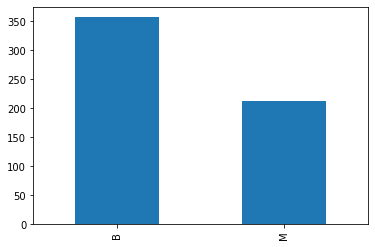

In [5]:
# View distribution of the diagnosis target column

df['diagnosis'].value_counts().plot(kind = 'bar')

In [6]:
# View dataset information

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [7]:
# AutoGluon infers target label as the last column

mc.MoveToLast(df,'diagnosis')
df.head(3)

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis
0,842302,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,M
1,842517,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,M
2,84300903,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,M


In [8]:
# View all feature columns

df.columns

Index(['id', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst', 'diagnosis'],
      dtype='object')

<AxesSubplot: >

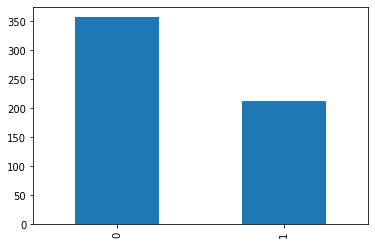

In [9]:
# Use LabelEncoder to encode categorical columns to numerical values and view class frequency distribution. 0 means benign and 1 means malignant.

le = preprocessing.LabelEncoder()
le.fit(df['diagnosis'])
df['diagnosis'] = le.transform(df['diagnosis'])

df['diagnosis'].value_counts().plot(kind = 'bar')

In [10]:
# Split the data into 80% training and 20% testing

train_data,test_data = train_test_split(df, test_size=0.2, random_state = 42)

print(f'Train data shape: {train_data.shape[0]}')
print(f'Test data shape: {test_data.shape[0]}')

Train data shape: 455
Test data shape: 114


## Train a Tabular Predictor

Build a Tabular Predictor using AutoGluon.

In [11]:
save_path = 'ag_breast_cancer'

# Clear or delete if folder exists
DO_DELETE = True 

if DO_DELETE:
  try:
    tf.compat.v1.gfile.DeleteRecursively(OUTPUT_DIR)
  except:
    pass

tf.io.gfile.makedirs(save_path)
print(f'Model output directory: {save_path}')

Model output directory: ag_breast_cancer


In [12]:
# Assign the target label column

label = 'diagnosis'
print("Summary of class variable: \n", train_data[label].describe())

Summary of class variable: 
 count    455.000000
mean       0.371429
std        0.483719
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: diagnosis, dtype: float64


In [13]:
# Set the target label, output directory, and evaluation metric to fit the model. Here, we set a time_limit to 120 seconds for efficiency.
# You can remove this setting to train at full duration if needed. For example:
# predictor = TabularPredictor(label=label, path=save_path, eval_metric='accuracy').fit(train_data, presets='best_quality')

predictor = TabularPredictor(label=label, path=save_path, eval_metric='accuracy').fit(train_data, time_limit=120, presets='best_quality')

Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=0, num_bag_folds=5, num_bag_sets=20
Beginning AutoGluon training ... Time limit = 120s
AutoGluon will save models to "ag_breast_cancer/"
AutoGluon Version:  0.6.2
Python Version:     3.9.10
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #1 SMP Wed Oct 26 20:36:53 UTC 2022
Train Data Rows:    455
Train Data Columns: 31
Label Column: diagnosis
Preprocessing data ...
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [0, 1]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Selected class <--> label mapping:  class 1 = 1, class 0 = 0
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:       

## Evaluate Model Performance

We can evaluate the performance of trained models using test data:

In [14]:
predictor.leaderboard(test_data, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,LightGBMLarge_BAG_L1,0.973684,0.962637,0.032009,0.009252,5.515525,0.032009,0.009252,5.515525,1,True,13
1,ExtraTreesEntr_BAG_L1,0.973684,0.973626,0.077688,0.121431,0.538665,0.077688,0.121431,0.538665,1,True,9
2,ExtraTreesGini_BAG_L1,0.973684,0.969231,0.079396,0.116677,0.508318,0.079396,0.116677,0.508318,1,True,8
3,NeuralNetTorch_BAG_L1,0.973684,0.980220,0.118211,0.141089,6.806376,0.118211,0.141089,6.806376,1,True,12
4,CatBoost_BAG_L1,0.964912,0.967033,0.054617,0.007347,10.413569,0.054617,0.007347,10.413569,1,True,7
5,RandomForestEntr_BAG_L1,0.964912,0.964835,0.070802,0.115942,0.587587,0.070802,0.115942,0.587587,1,True,6
6,RandomForestGini_BAG_L1,0.964912,0.967033,0.074424,0.113841,0.535838,0.074424,0.113841,0.535838,1,True,5
7,NeuralNetFastAI_BAG_L1,0.964912,0.986813,0.218847,0.157784,6.614334,0.218847,0.157784,6.614334,1,True,10
8,WeightedEnsemble_L2,0.964912,0.986813,0.221897,0.159605,7.207708,0.003050,0.001822,0.593374,2,True,14
9,LightGBMXT_BAG_L1,0.964912,0.982418,0.395568,0.010433,4.031775,0.395568,0.010433,4.031775,1,True,3


Let's obtain predictions for test data using the AutoGluon trained model.

In [15]:
y_test = test_data[label]

test_data_nolab = test_data.drop(columns=[label])
test_data_nolab.head()

,id,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
204,87930,12.47,18.60,81.09,481.9,0.09965,0.1058,0.08005,0.03821,0.1925,...,14.97,24.64,96.05,677.9,0.1426,0.2378,0.2671,0.10150,0.3014,0.08750
70,859575,18.94,21.31,123.60,1130.0,0.09009,0.1029,0.10800,0.07951,0.1582,...,24.86,26.58,165.90,1866.0,0.1193,0.2336,0.2687,0.17890,0.2551,0.06589
131,8670,15.46,19.48,101.70,748.9,0.10920,0.1223,0.14660,0.08087,0.1931,...,19.26,26.00,124.90,1156.0,0.1546,0.2394,0.3791,0.15140,0.2837,0.08019
431,907915,12.40,17.68,81.47,467.8,0.10540,0.1316,0.07741,0.02799,0.1811,...,12.88,22.91,89.61,515.8,0.1450,0.2629,0.2403,0.07370,0.2556,0.09359
540,921385,11.54,14.44,74.65,402.9,0.09984,0.1120,0.06737,0.02594,0.1818,...,12.26,19.68,78.78,457.8,0.1345,0.2118,0.1797,0.06918,0.2329,0.08134


In [16]:
# Obtain predictions on test data

#predictor = TabularPredictor.load(save_path) 

y_pred = predictor.predict(test_data_nolab)
print("Predictions:  \n", y_pred)
perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True)

Evaluation: accuracy on test data: 0.9649122807017544
Evaluations on test data:
{
    "accuracy": 0.9649122807017544,
    "balanced_accuracy": 0.9626596790042581,
    "mcc": 0.9253193580085162,
    "f1": 0.9534883720930233,
    "precision": 0.9534883720930233,
    "recall": 0.9534883720930233
}


Predictions:  
 204    0
70     1
131    1
431    0
540    0
      ..
486    0
75     1
249    0
238    0
265    1
Name: diagnosis, Length: 114, dtype: int64


In [17]:
# Obtain predicted class probabilities

pred_probs = predictor.predict_proba(test_data_nolab)
pred_probs.head(5)

,0,1
204,0.950747,0.049253
70,0.001357,0.998643
131,0.017722,0.982278
431,0.985273,0.014727
540,0.991829,0.008171


In [18]:
# View training summary

results = predictor.fit_summary(show_plot=True)

*** Summary of fit() ***
Estimated performance of each model:
                      model  score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0    NeuralNetFastAI_BAG_L1   0.986813       0.157784   6.614334                0.157784           6.614334            1       True         10
1       WeightedEnsemble_L2   0.986813       0.159605   7.207708                0.001822           0.593374            2       True         14
2         LightGBMXT_BAG_L1   0.982418       0.010433   4.031775                0.010433           4.031775            1       True          3
3     NeuralNetTorch_BAG_L1   0.980220       0.141089   6.806376                0.141089           6.806376            1       True         12
4     ExtraTreesEntr_BAG_L1   0.973626       0.121431   0.538665                0.121431           0.538665            1       True          9
5            XGBoost_BAG_L1   0.971429       0.019982   3.006738                

In [19]:
print("AutoGluon infers problem type is: ", predictor.problem_type)
print("AutoGluon identified the following types of features:")
print(predictor.feature_metadata)

AutoGluon infers problem type is:  binary
AutoGluon identified the following types of features:
('float', []) : 30 | ['radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean', ...]
('int', [])   :  1 | ['id']


## Explain a Model with SHAP

We are ready to use Kernel SHAP to explain the model's prediction and visualize Shapley values using different plots provided by SHAP.

In [20]:
# Load a previously saved trained model

loaded_predictor = TabularPredictor.load('ag_breast_cancer/')

In [21]:
# Create a function to get predictions on test data and pass them to KernelExplainer 

columns = train_data.columns

def get_predictions(input):
    df = pd.DataFrame(input, columns=columns)
    return predictor.predict(df)

data = np.array(train_data.values.tolist())

explainer = shap.KernelExplainer(get_predictions, data)

Using 455 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [22]:
# For efficiency, set a value for nsamples to limit the number of times SHAP re-evaluates the model when explaining each prediction. Try to tune this number if needed.

shap_values = explainer.shap_values(test_data, nsamples=20)

  0%|          | 0/114 [00:00<?, ?it/s]

In [23]:
print(f'SHAP values length: {len(shap_values)}')

SHAP values length: 114


## Visualize SHAP

SHAP provides various visualization to interpret feature importance based on SHAP values. Let's see a few examples.

### SHAP Force Plot

The SHAP force plot shows which features influenced the model’s prediction for a single observation. Starting at the base value, we can see the increment or decrement of each feature leads us to the final prediction for this sample. Red means the feature pushes the prediction higher to the right, while blue push a lower value prediction to the left. 

In [24]:
# Load JS visualization code
shap.initjs()

# Explain a specific instance
shap.force_plot(explainer.expected_value, shap_values=shap_values[5], features=test_data.iloc[1,:])

In [25]:
# Explain a specific instance
shap.force_plot(explainer.expected_value, shap_values=shap_values[0], features=test_data.iloc[1,:])

### Decision Plot

We can aggregate and visualize SHAP values using a decision plot to understand the overall model behavior in decision-making. The features are ordered by descending importance, and the lines move upwards from the bottom at a base value to their final prediction. The X-axis represents SHAP values for each feature on the y-axis.

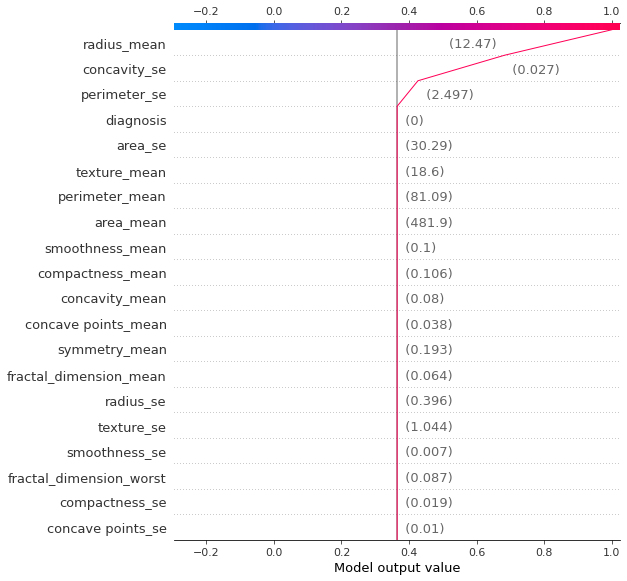

In [26]:
shap.decision_plot(explainer.expected_value, shap_values[5], test_data)

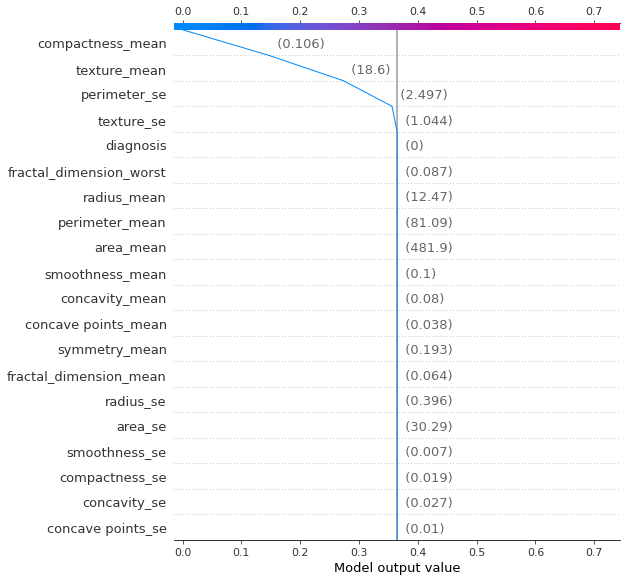

In [27]:
# Visualize a decision_plot

shap.decision_plot(explainer.expected_value, shap_values[0], test_data)

### Summary Bar Plot

The summary bar plot shows the mean absolute SHAP values for each feature across all observations, which is useful for analyzing the global effect of the features.

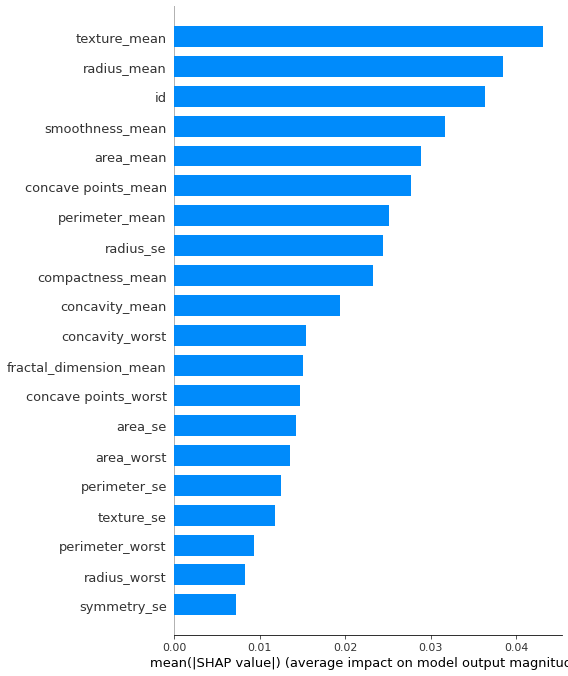

In [28]:
# Bar for multi-output
shap.summary_plot(shap_values, test_data, plot_type="bar")

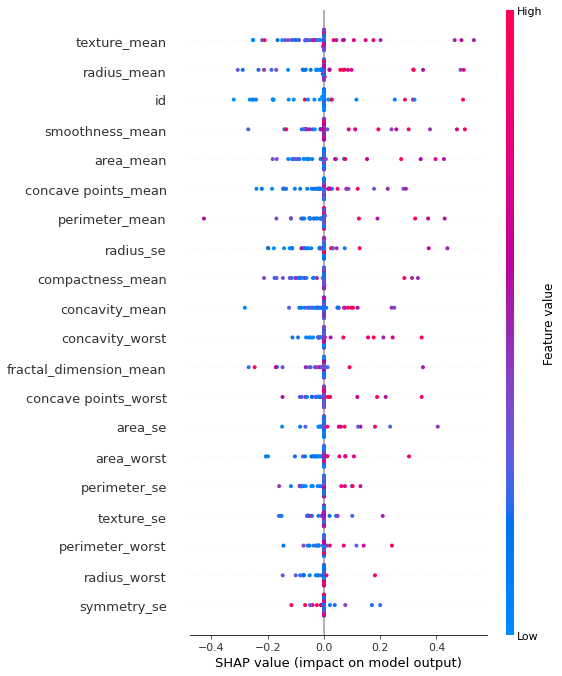

In [29]:
# Default dot visualization

shap.summary_plot(shap_values, test_data)

### Dependence Plot

A dependence plot shows a single feature attribution on the model predictions. For each data point, feature value is on the x-axis and the corresponding SHAP value is on the y-axis. The second feature is chosen by default.

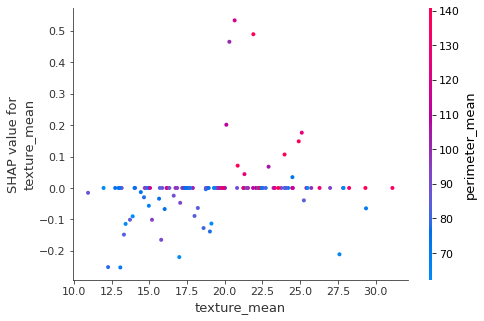

In [30]:
shap.dependence_plot(2, shap_values, test_data)

Alternatively, you can set a different second feature for comparison. In this case, texture_mean is set as the second feature.

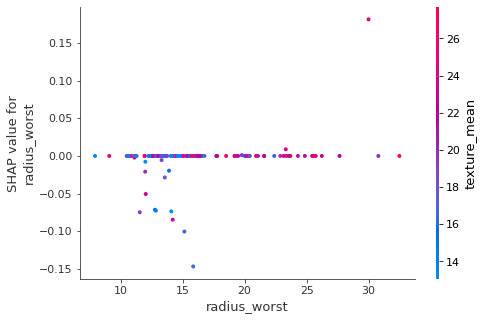

In [31]:
shap.dependence_plot('radius_worst', shap_values, test_data, interaction_index="texture_mean")

Kernel SHAP is model-agnostic. Hence it has wide applicability to interpret predictions for a broad range of ML models. However, Kernel SHAP can be time-consuming and computationally intensive, depending on the size of the dataset. We used the nsamples setting in this example to limit the number of SHAP evaluation for each prediction as an alternative. In contrast, [Amazon SageMaker Clarify](https://aws.amazon.com/sagemaker/clarify/) improves Kernel SHAP runtime significantly and enhances scalability by parallelizing SHAP computation. Refer to [Amazon SageMaker Clarify: Machine Learning Bias Detection and Explainability in the Cloud](https://assets.amazon.science/45/76/30bab4f14ccab96cfe8067ed2b4a/amazon-sagemaker-clarify-machine-learning-bias-detection-and-explainability-in-the-cloud.pdf) for more info on Amazon SageMaker Clarify's implementation of Kernel SHAP.